Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
## If you are using the data by mounting the google drive, use the following :

from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


In [ ]:
## unzipping the training and test datasets 

!unzip gdrive/MyDrive/CNN_Assignment/CNN_assignment.zip

Archive:  gdrive/MyDrive/CNN_Assignment/CNN_assignment.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024707.jpg  
  inf

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset

data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [ ]:
# displaying the count of images present in train and test dataset

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Number of images present in trainining set: "+ str(image_count_train))
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Number of images present in test set: "+ str(image_count_test))

Number of images present in trainining set: 2239
Number of images present in test set: 118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, batch_size= batch_size, image_size= (img_height, img_width),
    seed= 123, validation_split= 0.2, subset= 'training'
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, batch_size= batch_size, image_size= (img_height, img_width),
    seed= 123, validation_split= 0.2, subset= 'validation'
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

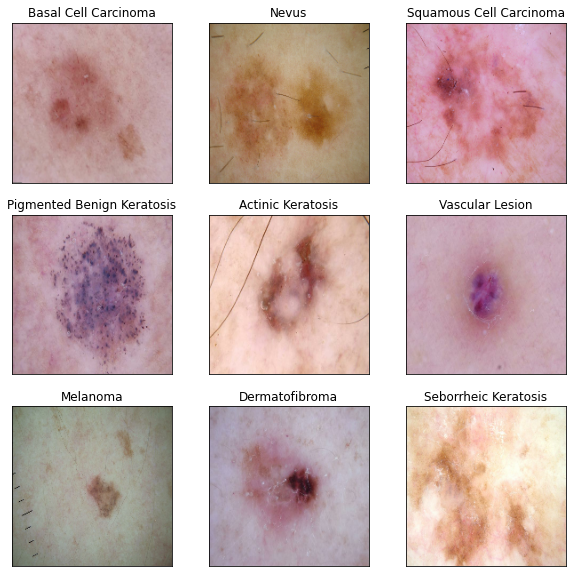

In [51]:
### your code goes here, you can use training or validation data to visualize

fig= plt.figure(figsize= (10, 10))

class_plot= [] 
plot_iter= 1

for img, lab in train_ds.take(1): 
  for i in range(len(lab)):
    if class_names[lab[i]] not in class_plot: 
      class_plot.append(class_names[lab[i]])
      plt.subplot(3,3,plot_iter)
      plt.imshow(img[i].numpy().astype('uint8'))
      plt.xticks([])
      plt.yticks([])
      plt.title(str(class_names[lab[i]]).title())
      plot_iter+=1
    elif class_names[lab[i]] in class_plot:
      pass
    elif len(class_plot)==9: 
      break

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
### Your code goes here

num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [ ]:
### Todo, choose an appropirate optimiser and loss function

model.compile(optimizer='adam',
              loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits= True),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

### Train the model

In [ ]:
## training the model

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 46s 82ms/step - loss: 2.2179 - accuracy: 0.1911 - val_loss: 1.9227 - val_accuracy: 0.2908
Epoch 2/20
56/56 [==============================] - 1s 20ms/step - loss: 1.9125 - accuracy: 0.3034 - val_loss: 1.6946 - val_accuracy: 0.3937
Epoch 3/20
56/56 [==============================] - 1s 20ms/step - loss: 1.6898 - accuracy: 0.3915 - val_loss: 1.5147 - val_accuracy: 0.5213
Epoch 4/20
56/56 [==============================] - 1s 20ms/step - loss: 1.4700 - accuracy: 0.4857 - val_loss: 1.4418 - val_accuracy: 0.5190
Epoch 5/20
56/56 [==============================] - 1s 20ms/step - loss: 1.4114 - accuracy: 0.4991 - val_loss: 1.4169 - val_accuracy: 0.5145
Epoch 6/20
56/56 [==============================] - 1s 20ms/step - loss: 1.2469 - accuracy: 0.5673 - val_loss: 1.4618 - val_accuracy: 0.5056
Epoch 7/20
56/56 [==============================] - 1s 20ms/step - loss: 1.2019 - accuracy: 0.5721 - val_loss: 1.5448 - val_accuracy: 0.4810
Epoch 8/20
5

### Visualizing training results

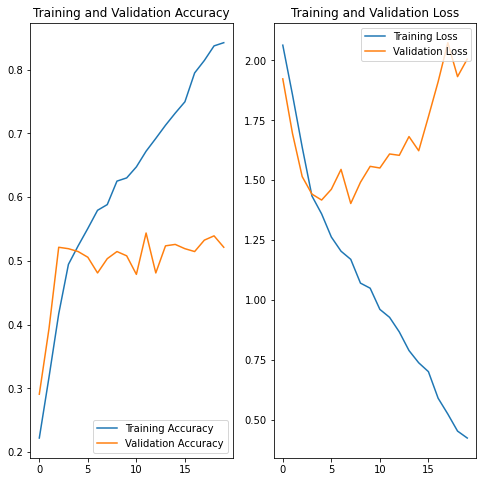

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Write your findings here
#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

- As we can see the training and validation accuracy, the training set is having accuracy of approximately 85% and validation set is having accuracy of approximately 52% accuracies. 
- As the difference between the accuracy of training and validation is too high, this model is tending to overfit. 

## Data augmentation

- Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.


In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

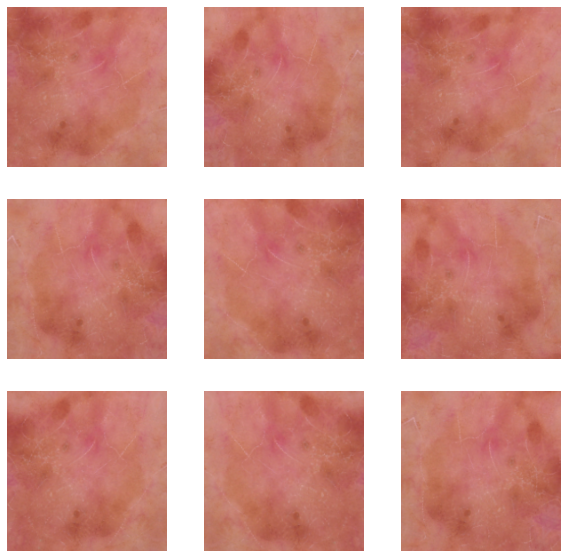

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
## Dropout

- A technique to reduce overfitting is to introduce Dropout to the network, a form of regularization.

- When we apply Dropout to a layer it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.


### Create the model, compile and train the model

In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
## Your code goes here

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


### Compiling the model

In [ ]:
## Your code goes here

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
## training the model

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 2s 28ms/step - loss: 2.1575 - accuracy: 0.1952 - val_loss: 1.9962 - val_accuracy: 0.2170
Epoch 2/20
56/56 [==============================] - 1s 22ms/step - loss: 1.9362 - accuracy: 0.2924 - val_loss: 1.9110 - val_accuracy: 0.2617
Epoch 3/20
56/56 [==============================] - 1s 22ms/step - loss: 1.7471 - accuracy: 0.3644 - val_loss: 1.7012 - val_accuracy: 0.4340
Epoch 4/20
56/56 [==============================] - 1s 22ms/step - loss: 1.5457 - accuracy: 0.4469 - val_loss: 1.4648 - val_accuracy: 0.4966
Epoch 5/20
56/56 [==============================] - 1s 22ms/step - loss: 1.4859 - accuracy: 0.4704 - val_loss: 1.3889 - val_accuracy: 0.5347
Epoch 6/20
56/56 [==============================] - 1s 22ms/step - loss: 1.3253 - accuracy: 0.5586 - val_loss: 1.3564 - val_accuracy: 0.5391
Epoch 7/20
56/56 [==============================] - 1s 22ms/step - loss: 1.2776 - accuracy: 0.5440 - val_loss: 1.4336 - val_accuracy: 0.5235
Epoch 8/20
56

### Visualizing the results

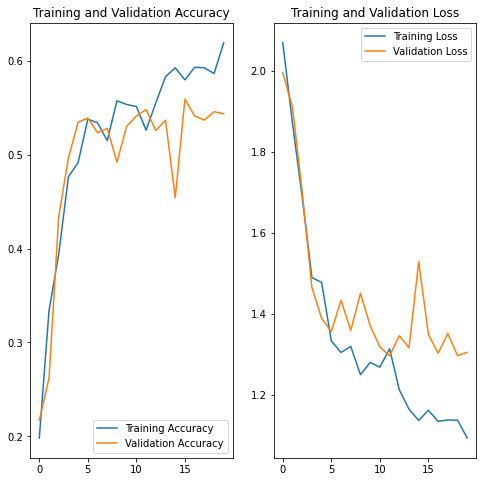

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:** Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

- As we have done the data augmentation and dropout technique to overcome the overfitting issue generated when we have built a basic network. 
- But, the performance of the model has been decreased. i.e., training data is having accuracy of approximately 62% and validation data is having accuracy of approximately 54%.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
## Your code goes here.
# to store the value of classes present in dictionary

class_dict= {}

for element in train_ds.as_numpy_iterator(): 
  for i in element[1]: 
    if class_names[i] in class_dict.keys(): 
      class_dict[class_names[i]]+=1
    else: 
      class_dict[class_names[i]]= 1

class_dict

{'actinic keratosis': 92,
 'basal cell carcinoma': 309,
 'dermatofibroma': 77,
 'melanoma': 352,
 'nevus': 277,
 'pigmented benign keratosis': 370,
 'seborrheic keratosis': 58,
 'squamous cell carcinoma': 142,
 'vascular lesion': 115}

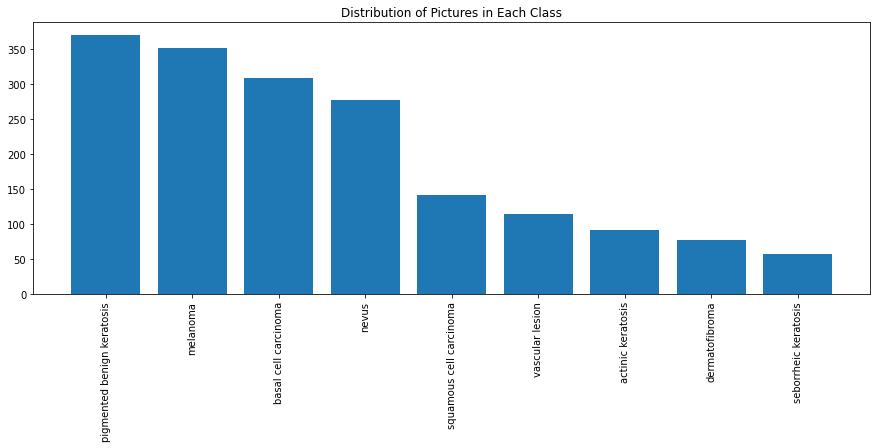

In [ ]:
# to visualize the count of pictures present in each class 

class_df= pd.DataFrame(class_dict.items(), columns= ['Class', 'Count'])
class_df.sort_values(by= 'Count', ascending= False, inplace= True, ignore_index= True)

plt.figure(figsize= (15,5))
plt.bar(class_df['Class'],class_df['Count'])
plt.title("Distribution of Pictures in Each Class")
plt.xticks(rotation = 90)
plt.show()

#### **Todo:** Write your findings here: 
- #### Which class has the least number of samples?
  - *Seborrheic Keratosis* is having the least number of sample among all the 9 classes of cancer data.
- #### Which classes dominate the data in terms proportionate number of samples?
  - The following classes are having the dominating number of samples: 
    - *Pigmented Benign Keratosis* - 370 samples
    - *Melanoma* - 352 samples 
    - *Basal Cell Carcinoma* - 309 samples


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
# installing augmentor 

!pip install Augmentor

In [ ]:
# importing augmentor

import Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FCBD45139D0>: 100%|██████████| 500/500 [00:16<00:00, 30.75 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FCBD41C97D0>: 100%|██████████| 500/500 [00:16<00:00, 30.74 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FCBD41E9B90>: 100%|██████████| 500/500 [00:16<00:00, 31.22 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FCBD457DC90>:   0%|          | 1/500 [00:00<01:13,  6.75 Samples/s]                  

Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FCBD4513910>: 100%|██████████| 500/500 [01:23<00:00,  5.96 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x7FCBD424B5D0>:   0%|          | 1/500 [00:00<01:17,  6.45 Samples/s]

Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FCBD42E4F50>: 100%|██████████| 500/500 [01:20<00:00,  6.24 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FCBD4235550>: 100%|██████████| 500/500 [00:16<00:00, 30.90 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FCBD46A8FD0>: 100%|██████████| 500/500 [00:41<00:00, 12.11 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FCBD45EFF10>: 100%|██████████| 500/500 [00:16<00:00, 29.77 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FCBD45FC050>:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FCBD42D9B90>: 100%|██████████| 500/500 [00:16<00:00, 30.44 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
# let's check the count of new samples added in all the classes

image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026693.jpg_07dc9bcf-1c8b-4f1f-a1a7-9ca1db079b6a.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0028885.jpg_c3037306-d870-4101-8e62-e27374a69c58.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0028885.jpg_acdc04f4-cc7b-44e8-b18c-6eb39a3d1172.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027903.jpg_d1c24471-bb5e-4a9f-9091-fd1b126ccac1.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025425.jpg_dcada165-861b-4c15-9e23-ca5ce8bb7e95.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_o

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',


In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
path_list_old = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
path_list_old

['Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0032270.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0027903.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0027888.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0027563.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0027269.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0030956.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0032538.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0026456.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0029742.jpg',
 'Skin cancer ISIC The International Skin Imaging Colla

In [ ]:
lesion_list_old = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list_old

['vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',


In [ ]:
dataframe_dict_old = dict(zip(path_list_old, lesion_list_old))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
original_df = pd.DataFrame(list(dataframe_dict_old.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [ ]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
# creating a train data using original and augmented data 

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [ ]:
# creating a validation data using original and augmented data 

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
## your code goes here

model1 = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
## your code goes here

model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers

model1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 22, 22, 64)       

#### **Todo:**  Train your model

In [ ]:
## Your code goes here, use 30 epochs.

epochs = 30
history1 = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 34s 189ms/step - loss: 1.8694 - accuracy: 0.2750 - val_loss: 1.6991 - val_accuracy: 0.3816
Epoch 2/30
169/169 [==============================] - 33s 188ms/step - loss: 1.5311 - accuracy: 0.4333 - val_loss: 1.3552 - val_accuracy: 0.4981
Epoch 3/30
169/169 [==============================] - 33s 187ms/step - loss: 1.3551 - accuracy: 0.4857 - val_loss: 1.1901 - val_accuracy: 0.5627
Epoch 4/30
169/169 [==============================] - 33s 187ms/step - loss: 1.2558 - accuracy: 0.5214 - val_loss: 1.2408 - val_accuracy: 0.5301
Epoch 5/30
169/169 [==============================] - 32s 186ms/step - loss: 1.2367 - accuracy: 0.5281 - val_loss: 1.3663 - val_accuracy: 0.5197
Epoch 6/30
169/169 [==============================] - 32s 185ms/step - loss: 1.1545 - accuracy: 0.5546 - val_loss: 1.2566 - val_accuracy: 0.5494
Epoch 7/30
169/169 [==============================] - 32s 184ms/step - loss: 1.0821 - accuracy: 0.5902 - val_loss: 1.0292 - val_ac

#### **Todo:**  Visualize the model results

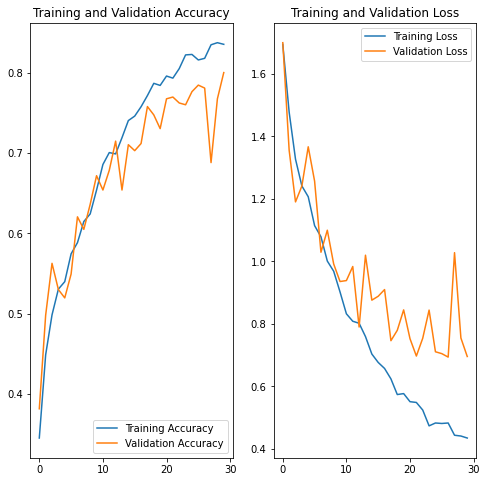

In [ ]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

- The final model has run with dealing the overfitting and class rebalance by using augmentation method. 

- When compared to earlier models, this model has training accuracy of approximately 83% and validation accuracy of 80% which dealt with overfitting issue and also the class rebalance had helped the model to improve the performance. 
